In [1]:
from train_dataset import *
from test_dataset import *
from neural_network import *
from train_method import *
from evaluate import *

In [2]:
train_set = TrafficSignTrain()
test_set = TrafficSignTest()
print(len(train_set))
print(len(test_set))

39209
12630


In [3]:
hist = train_data("../checkpoint", "NoneHiddenlayer", resume = True, num_epochs = 1)

iterate 1: loss = 2.197811127, spent = 0.02816


KeyboardInterrupt: 

[1.0887553116845083e-06, 0.017276514321565628, 0.00011166003969265148]


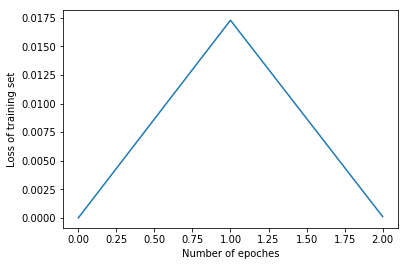

Loss = 1.491140
Acc = 71.243072 percent
Time per image: 0.000831 seconds: 


In [4]:
evaluate("../checkpoint", "NoneHiddenlayer", test_set)